<a href="https://www.kaggle.com/code/shreyasdomde/wildfire?scriptVersionId=164896724" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import plot_model

2024-02-29 17:41:42.694132: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 17:41:42.694228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 17:41:42.824257: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploring Dataset

In [2]:
# Image Paths
train_path = '/kaggle/input/wildfirev1/train'
val_path = '/kaggle/input/wildfirev1/valid'
test_path = '/kaggle/input/wildfirev1/test'

# Annotations Paths
train_annot = pd.read_csv('/kaggle/input/wildfirev1/train/_annotations.csv')
valid_annot = pd.read_csv('/kaggle/input/wildfirev1/valid/_annotations.csv')
test_annot = pd.read_csv('/kaggle/input/wildfirev1/test/_annotations.csv')

In [3]:
# Overview of annot.csv
train_annot.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,ck0qd8gs6ko7j0721x25cv4o3_jpeg.rf.005f5707706e...,640,480,smoke,125,190,177,286
1,ck0t40rhdz68s0a46ekx049a6_jpeg.rf.00403179fe5f...,640,480,smoke,326,207,494,249
2,ck0m0ch9ugnna07940o8x989j_jpeg.rf.0101cdb46a16...,640,480,smoke,308,166,582,257
3,ck0rr6bfa9b3w0721aw5unwdy_jpeg.rf.00982c053d66...,640,480,smoke,241,204,310,244
4,ck0uk75x5ysls0721e5a9j891_jpeg.rf.00d7fd8503e1...,640,480,smoke,523,208,619,288


In [4]:
def Bounding_box(image, annotations):
    
    for index, row in annotations.iterrows():
        
        print(row[['xmin', 'ymin', 'xmax', 'ymax']])
        x1 = int(row["xmin"])
        y1 = int(row["ymin"])
        x2 = int(row["xmax"])
        y2 = int(row["ymax"])
        label = row["class"]
        
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return image

In [5]:
def View_image_from_dir(path, ind):
    annot_path = pd.read_csv(os.path.join(path, '_annotations.csv'))
    
    for i in os.listdir(path)[ind:]:
        img = cv2.imread(os.path.join(path, i), cv2.IMREAD_COLOR)
        image_annotations = annot_path[annot_path['filename'] == i]
        annotated_image = Bounding_box(img, image_annotations)
        plt.imshow(annotated_image)
        break

xmin    162
ymin    210
xmax    635
ymax    302
Name: 1, dtype: object


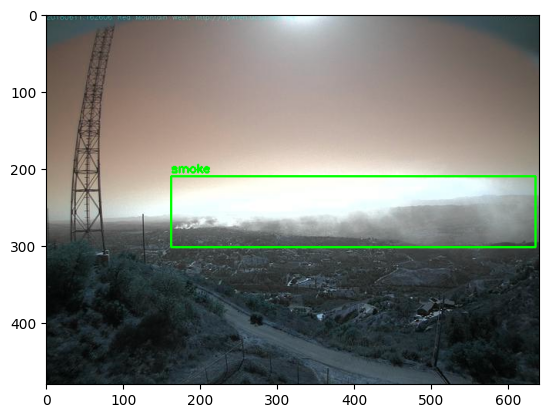

In [6]:
View_image_from_dir(test_path, 2)

# Preprocessing Images and annotations


In [7]:
input_size = (300, 300)

In [8]:
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    resize_img = cv2.resize(img, input_size)
    rescaled_img = resize_img/255.0
    return rescaled_img

def load_data(directory):
    annots = pd.read_csv(os.path.join(directory, '_annotations.csv'))
    images = []
    boundingBoxes = []
    for index, row in annots.iterrows():
        img_path = os.path.join(directory, row['filename'])
        try:
            pre_img = preprocess_image(img_path)
            images.append(pre_img)
            
            x1 = (row["xmin"]/row['width']*input_size[1])
            y1 = (row["ymin"]/row['height']*input_size[0])
            x2 = (row["xmax"]/row['width']*input_size[1])
            y2 = (row["ymax"]/row['height']*input_size[0])

            bounds = [x1, y1, x2, y2]
            boundingBoxes.append(bounds)
        except Exception as error:
            print(error)
            continue   

    return np.array(images), np.array(boundingBoxes, dtype=np.float32)

In [9]:
X_train, y_train = load_data(train_path)
X_valid, y_valid = load_data(val_path)
X_test, y_test = load_data(test_path)

# Model Building

In [10]:
class Model:
    
    def __init__(self, inputs):
        
        self.inputs = inputs
        self.feature_extractor = self.build_feature_extractor()
        self.model_adaptor = self.build_model_adaptor(self.feature_extractor)
        self.regressor_head = self.build_regressor_head(self.model_adaptor)
        
    def build_feature_extractor(self):
        x = tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(300, 300, 3))(self.inputs)
        x = tf.keras.layers.MaxPooling2D(2,2)(x)

        x = tf.keras.layers.Conv2D(64, kernel_size=3, activation = 'relu')(x)
        x = tf.keras.layers.MaxPooling2D(2,2)(x)
        
        return x
    
    def build_model_adaptor(self, inputs):
        
        x = tf.keras.layers.Flatten()(inputs)
        x = tf.keras.layers.Dense(64, activation='relu')(x)  
        return x

    def build_regressor_head(self, inputs):
        x = tf.keras.layers.Dense(units = '4', name = 'regressor_head')(inputs)
        return x                    
    
    def build_model(self):
        
        model = tf.keras.Model(inputs = self.inputs, outputs=[self.regressor_head])
        return model

In [11]:
model = Model(tf.keras.layers.Input(shape=(300, 300, 3, )))

model = model.build_model()

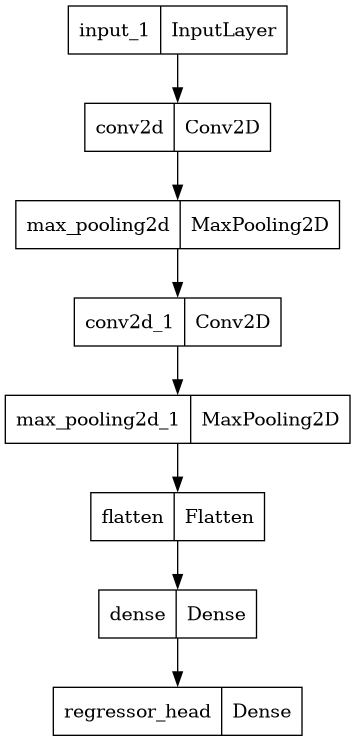

In [12]:
plot_model(model, 'model.png')

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss='mean_squared_error')

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience = 10,
    restore_best_weights = True,
    verbose = 1,
    min_delta = 0.001,
)

# Training model

In [15]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    channel_shift_range = 0.15
)

In [16]:
training_data = train_datagen.flow(X_train, y_train)

In [17]:
EPOCHS = 200
BATCH_SIZE = 32

In [18]:
history = model.fit(
    training_data,
#   X_train, y_train,
    validation_data = (X_valid, y_valid),
    callbacks = [early_stopping],
    batch_size = BATCH_SIZE,
    epochs = EPOCHS
)

Epoch 1/200


I0000 00:00:1709228528.628339      69 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 [==============================] - 8s 188ms/step - loss: 6132.9678 - val_loss: 3440.1587
Epoch 2/200
17/17 [==============================] - 2s 140ms/step - loss: 2736.5710 - val_loss: 1570.7146
Epoch 3/200
17/17 [==============================] - 2s 139ms/step - loss: 1784.5854 - val_loss: 1249.9412
Epoch 4/200
17/17 [==============================] - 2s 131ms/step - loss: 1024.9125 - val_loss: 740.6398
Epoch 5/200
17/17 [==============================] - 2s 132ms/step - loss: 710.9336 - val_loss: 692.5779
Epoch 6/200
17/17 [==============================] - 2s 132ms/step - loss: 531.3240 - val_loss: 498.7650
Epoch 7/200
17/17 [==============================] - 2s 134ms/step - loss: 433.5314 - val_loss: 418.0798
Epoch 8/200
17/17 [==============================] - 2s 135ms/step - loss: 358.2825 - val_loss: 395.7787
Epoch 9/200
17/17 [==============================] - 2s 125ms/step - loss: 362.7457 - val_loss: 421.9993
Epoch 10/200
17/17 [==============================] - 2s 137

In [19]:
history_df = pd.DataFrame(history.history)

In [20]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 117ms/step - loss: 83.8057


83.80574798583984

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


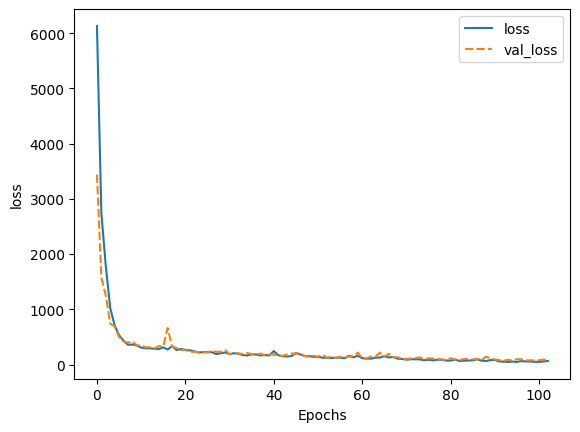

In [21]:
sns.lineplot(data = history_df.loc[:, ['loss', 'val_loss']])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

# Predicting Testing image

In [22]:
y_pred = model.predict(X_test)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 15ms/step - loss: 83.8057


83.80574798583984

In [23]:
def Show_predicted_image(ind):
    
    xmin, ymin, xmax, ymax = y_pred[ind]
    x1, y1, x2, y2 = y_test[ind]
    print('Predicted: ', [xmin, ymin, xmax, ymax],
         '\nOriginal: ', [x1, y1, x2, y2])
    
    img = X_test[ind].copy()
    height, width, _ = img.shape 
    
    cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 0, 255), 1)
    cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 0), 1)
    
    cv2.putText(img, 'Predicted', (int(xmin), int(ymin)+20), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
    cv2.putText(img, 'Original', (int(x1), int(y1)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1)
    print('PREDICTED IMAGE:')
    plt.imshow(img)

Predicted:  [89.344124, 108.24394, 194.47821, 192.54161] 
Original:  [83.90625, 104.375, 189.375, 193.75]
PREDICTED IMAGE:


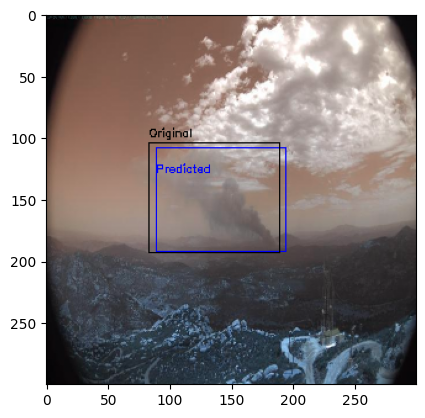

In [24]:
Show_predicted_image(20)